## Tutorial notebook: Generating SimBA dataset parameters for *a single bias subgroup* in a *binary disease classification task*

**The general steps for this are:**
1. Define distribution of subject effects, such that this distribution is the same in each disease class. 
2. Define distribution of disease effects for each class, and then perform stratified splitting of simulated "subjects" (defined by disease + subject effects) into the "bias" and "no bias" subgroups

Import libraries, define sampling parameters: 

In [77]:
import numpy as np
import pandas as pd
import argparse
from pathlib import Path
from numpy.random import Generator, PCG64
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from utils import merge_shuffle_data
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
SEED_D  = 7 #seed for disease class
SEED_ND = 4 #seed for non-disease class
SEED_S = 2 #seed for subject effects
TOTAL_N = 2160 #total number of samples to start with
D_FRAC = 0.5 #fraction of total samples in disease class
MU_D = 1 #mean of distribution for disease class
MU_ND = -1 #mean of distribution for non-disease class
SD_D = 1 #std of effect sampling dst
ISV = True #whether to include subject effects
MU_S = 0 #mean of subject sampling dst
SD_S = 1 #std of subject sampling dst
LOWER_S = -3.5 #lower bound of subject sampling dst
UPPER_S = 3.5 #upper bound of subject sampling dst
BIAS_FRAC_D = 0.7 #fraction of bias group in disease class
BIAS_FRAC_ND = 0.3 #fraction of bias group in non-disease class
BINS_D = 10 #number of bins for disease effect stratification
BINS_S = 10 #number of bins for subject effect stratification
TRAIN_FRAC = 0.5 #fraction of dataset to split into training set
VAL_FRAC = 0.25 #fraction of dataset to split into validation set
TEST_FRAC = 0.25 #fraction of dataset to split into test set
EXP = 'test_exp' #experiment name

Note that `TOTAL_N` will not be the final number of images in the dataset, since we will be undersampling data to maintain stratification. Therefore, some guess + check on initial value of `TOTAL_N` may be required to end up with a desired dataset size.

### 1. Define distribution of subject effects, such that this distribution is the same in each disease class. 

For both subject and disease effects, we define "bins" comprised of a range of values corresponding to effect magnitude along the PC subspace. To ensure that the bias subgroups are stratified by subject and disease effects, we add the desired proportion of "bias" to "no bias" samples to each bin. 

In [79]:
#function to generate sampling distributions
def get_class_distributions(seed, mu, sd, num, d_frac, lower_bound, upper_bound, bins):
    '''
    get dataframe with subject effects for each disease class
    
    -----inputs------
    -seed: seed for deterministic random number generation
    -mu: mean value of subject effect sampling distribution
    -sd: standard deviation of subject effect sampling distribution
    -num: number of samples to generate
    -d_frac: fraction of all data defined as the disease class
    -lower_bound: lower bound of truncated gaussian distribution for subject sampling
    -upper_bound: upper bound of truncated gaussian distribution for subject sampling
    -bins: number of bins for subject effect stratification
    -----outputs-----
    -isv_nd: subject effect distribution for the non-disease class
    -isd_d: subject effect distribution for the disease_class
    '''
    #define subject effect distribution
    numpy_randomGen = Generator(PCG64(seed))
    truncnorm.random_state=numpy_randomGen

    isv_dst_mean = mu #mean value of component for generating distribution of samples
    isv_dst_sd = sd #standard deviation for generating distirbution of samples
    isv_dst_bounds = [lower_bound, upper_bound]
    isv_dst_raw = truncnorm.rvs((isv_dst_bounds[0]-isv_dst_mean)/isv_dst_sd, (isv_dst_bounds[1]-isv_dst_mean)/isv_dst_sd, loc=isv_dst_mean, scale=isv_dst_sd, size=num)
    isv_bins = pd.cut(isv_dst_raw, bins=bins, labels=False)
    s = {'isv_dst': isv_dst_raw,
         'isv_bin': isv_bins}

    isv_df = pd.DataFrame(data=s)
    w = isv_df.isv_bin.value_counts()
    bins_to_remove = w.index[w<=1].tolist()
    print('dropping {} bins from class sampling step'.format(len(bins_to_remove)))
    isv_to_split = isv_df[~isv_df['isv_bin'].isin(bins_to_remove)]
    isv_nd, isv_d = train_test_split(isv_to_split, test_size = d_frac, random_state=42, stratify=isv_to_split[['isv_bin']])

    return isv_nd, isv_d

In [80]:
#get subject effect distributions for disease and non-disease classes
isv_nd, isv_d = get_class_distributions(SEED_S, MU_S, SD_S, TOTAL_N, D_FRAC, LOWER_S, UPPER_S, BINS_S)
NUM_D = len(isv_d)
NUM_ND = len(isv_nd)

dropping 0 bins from class sampling step


### 2. Define distribution of disease effects for each class, and then perform stratified splitting of simulated "subjects" (defined by disease + subject effects) into the "bias" and "no bias" subgroups

In [81]:
def get_dataset_effects(seed, mu, sd, bias_frac, num_samples, isv, isv_dst, isv_bins, bins_d, bins_s, class_label):
    '''
    get dataframe with effects for all subjects in dataset with corresponding bias and class labels
    
    -----inputs------
    -seed: seed for deterministic random number generation
    -mu: mean value of disease effect sampling distribution
    -sd: standard deviation of disease effect sampling distribution
    -bias_frac: fraction of samples in this disease class to contain bias effect
    -num_samples: number of samples to generate for this class
    -isv: whether or not subject effects are included in this dataset (True/False)
    -isv_dst: stratified subject effect distribution for this class
    -isv_bins: bin values from subject effect stratification step
    -bins_d: number of stratificatin bins for disease effects 
    -bins_s: number of stratification bins defined for subject effects
    -class_label: numeric label for this disease class
    -----outputs-----
    -df: dataframe with subject effects, disease effects, bias labels, and class labels for this disease class
    '''
    numpy_randomGen = Generator(PCG64(seed))


    #generate disease effect distribution
    effect_dst_mean = mu #mean value of component for generating distribution of samples
    effect_dst_sd = sd #standard deviation for generating distribution of samples
    effect_dst_raw = numpy_randomGen.normal(effect_dst_mean, effect_dst_sd, num_samples) #get samples from disease effect distribution

    effect_bins = pd.cut(effect_dst_raw, bins=bins_d, labels=False)
    
    if ISV == True:
        d = {'isv_dst': isv_dst,
             'effect_dst': effect_dst_raw,
             'isv_bin': isv_bins,
             'effect_bin': effect_bins}

        df = pd.DataFrame(data=d)
        df['both_bins'] = df['isv_bin'].astype(str) +'_' + df['effect_bin'].astype(str)
        x = df.both_bins.value_counts()
        
        bins_to_remove = x.index[x<=2].tolist()
        print('dropping {} bins from bias sampling step'.format(len(bins_to_remove)))
        df_to_split = df[~df['both_bins'].isin(bins_to_remove)]
        #note that we are keeping bins with samples >2 here, but that means not all bins will have be split
        # precisely based on the bias fraction. would need to keep bins with min # of samples required for precise
        # proportions if desired. 
        
        nb, b = train_test_split(df_to_split, test_size = bias_frac, random_state=42, stratify=df_to_split[['both_bins']])

    else:
        #only stratifying disease effects
        d = {'effect_dst': effect_dst_raw,
             'effect_bin': effect_bins}

        df = pd.DataFrame(data=d)
        x = df.effect_bin.value_counts()
        bins_to_remove = x.index[x<=2].tolist()
        print('dropping {} bins from bias sampling step'.format(len(bins_to_remove)))
        df_to_split = df[~df['both_bins'].isin(bins_to_remove)]

        nb, b = train_test_split(df_to_split, test_size = bias_frac, random_state=42, stratify=df_to_split[['effect_bin']])


    nb['bias_label'] = 0
    b['bias_label'] = 1

    df = pd.concat([b,nb])
    df['class_label'] = class_label


    return df

In [82]:
#get disease effect distributions for each class, stratified within bias groups 
df_D = get_dataset_effects(SEED_D, MU_D, SD_D, BIAS_FRAC_D, NUM_D, ISV, isv_d['isv_dst'].values, isv_d['isv_bin'].values, BINS_D, BINS_S, 1)
df_ND = get_dataset_effects(SEED_ND, MU_ND, SD_D, BIAS_FRAC_ND, NUM_ND, ISV, isv_nd['isv_dst'].values, isv_nd['isv_bin'].values, BINS_D, BINS_S, 0)

dropping 24 bins from bias sampling step
dropping 20 bins from bias sampling step


In [83]:
#full list of effects for each subject 
df = merge_shuffle_data([df_D, df_ND])

### Combine dataframe for each class and perform stratified splits (based on subject effect, disease effect, and bias label) into train/val/test partitions:

In [84]:
if ISV == True:
    df['strat_col'] = df['class_label'].astype(str) +'_' + df['bias_label'].astype(str) + '_' + df['effect_bin'].astype(str) + '_' + df['isv_bin'].astype(str)
else:
    df['strat_col'] = df['class_label'].astype(str) +'_' + df['bias_label'].astype(str) + '_' + df['effect_bin'].astype(str)

In [85]:
#remove datasets with <=2 from full list, to prepare for train vs. val+test split
x = df.strat_col.value_counts()
bins_to_remove = x.index[x<=2].tolist()
print('dropping {} bins during training split'.format(len(bins_to_remove)))
df_to_split = df[~df['strat_col'].isin(bins_to_remove)]

dropping 59 bins during training split


In [86]:
#stratified train/val+test splits
train, valtest = train_test_split(df_to_split, test_size = TEST_FRAC + VAL_FRAC, stratify=df_to_split[['strat_col']], random_state=42)

In [87]:
#remove datasets with <=1 from valtest, to prepare for val vs. test split
y = valtest.strat_col.value_counts()
bins_to_remove = y.index[y<=1].tolist()
print('dropping {} bins during validation split'.format(len(bins_to_remove)))
valtest_to_split = valtest[~valtest['strat_col'].isin(bins_to_remove)]

#stratified val/test splits
val, test = train_test_split(valtest_to_split, test_size = (TEST_FRAC/(TEST_FRAC+VAL_FRAC)), stratify=valtest_to_split[['strat_col']], random_state=42)

print('Total samples after stratification: {}'.format(len(train) + len(val) + len(test)))

dropping 11 bins during validation split
Total samples after stratification: 1995


we can visualize the data distribution for our final dataset now: 

In [88]:
final_df = pd.concat([train, val, test])

Joint distribution of subject and disease effects:

Text(37.722222222222214, 0.5, 'Disease Effects')

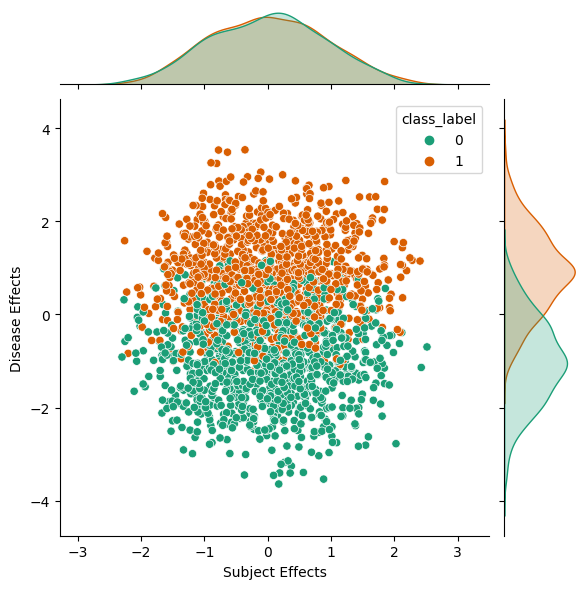

In [89]:
sns.jointplot(data=final_df, x='isv_dst', y='effect_dst', hue='class_label', palette='Dark2')
plt.xlabel('Subject Effects')
plt.ylabel('Disease Effects')

Joint distribution of subject and disease effects for the disease class:

Text(37.722222222222214, 0.5, 'Disease Effects')

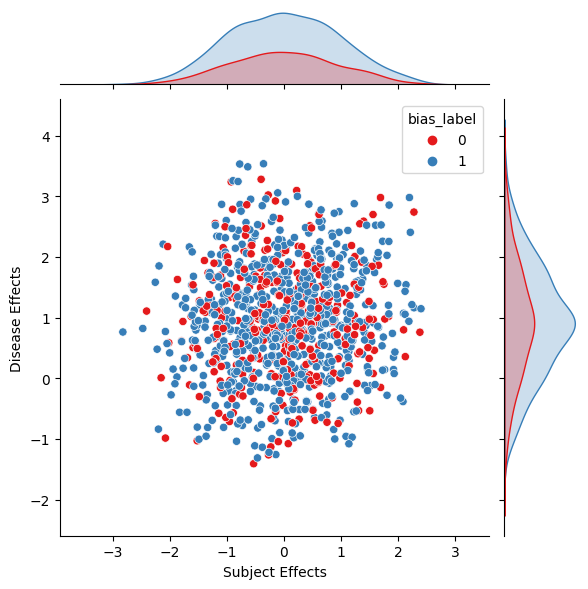

In [90]:
sns.jointplot(data=df.loc[df['class_label']==1], x='isv_dst', y='effect_dst', hue='bias_label', palette='Set1')
plt.xlabel('Subject Effects')
plt.ylabel('Disease Effects')

Joint distribution of subject and disease effects for the no disease class:

Text(37.722222222222214, 0.5, 'Disease Effects')

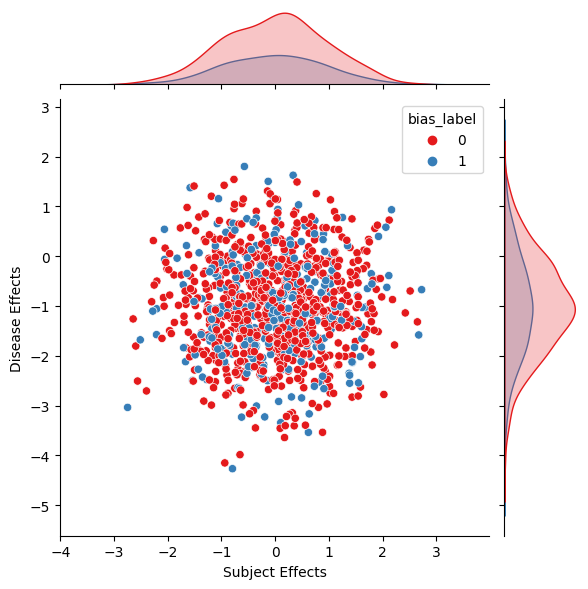

In [91]:
sns.jointplot(data=df.loc[df['class_label']==0], x='isv_dst', y='effect_dst', hue='bias_label', palette='Set1')
plt.xlabel('Subject Effects')
plt.ylabel('Disease Effects')

In [92]:
# save_dir = ...
# train.to_csv(save_dir + '/train_dst.csv')
# val.to_csv(save_dir + '/val_dst.csv')
# test.to_csv(save_dir + '/test_dst.csv')

These saved splits can now be used to generate data using `generate_data.py`.